<a href="https://colab.research.google.com/github/manusmriti31/Learning_PyTorch/blob/main/Video%20notebooks/06_pytorch_transfer_learning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

what is transfer learning?
Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem..
* Pretrained model = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


Importing the code we have written in the previous versions

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install if it is not there
try:
  from torchinfo import summary
except:
  print(f"[INFO] couldn't find torchinfo......installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular.going_modular import data_setup, engine
except:
  # Get the going_modular scripts
  print(f"[INFO] couldn't find going_modular scripts.. downloading them from GitHub.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

[INFO] couldn't find torchinfo......installing it.
[INFO] couldn't find going_modular scripts.. downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1540/1540), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 4393 (delta 1459), reused 1408 (delta 1401), pack-reused 2853 (from 1)
Receiving objects: 100% (4393/4393), 650.73 MiB | 39.40 MiB/s, done.
Resolving deltas: 100% (2661/2661), done.
Updating files: 100% (248/248), done.


In [3]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

we need our pizza, steak, sushi data to build a transfer learning model on.

In [4]:
import os
import zipfile
import requests

from pathlib import Path


# Setup data path
data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

# if the image folder does not exist download it and prepare it
if image_path.is_dir():
  print(f"{image_path} already exists hence skipping download...")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents = True, exist_ok = True)


  # dowloading pizza_steak_shushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza steak and sushi data...")
    f.write(request.content)

  # unzipping the pizza steak and sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the data")
    zip_ref.extractall(image_path)

  # Remove the .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")


Did not find data/pizza_steak_sushi, downloading it...
Unzipping the data


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Creat Datsets and DataLoaders
Now we've got some data, want to turn it into PyTorch DataLoaders.
To do so, we can use `data_setup.py` and the `create_dataloaders()` functions we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: how to **transform** it ?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms - you denfine what transforms you wnat your data to go through.
2. Automatically created transforms - trhe transforms for your data are defined by the model you'd like to use.

**Important Point**: When using a pretrained model, it's important that the data(including your custom data) that you pass through it is **transformed** in the same way that the data the mdoel was trained on

### 2.1 Creating a transfrom from `torchvision.model` (manual creation)
`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.

In [6]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [7]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transform,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cd8c0cb1420>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)
As of torchvision v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
from enum import auto
# Get the transform used to create our pretrained weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create Dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transform,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cd8c0cb13c0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting  a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. paperswithcode (for mdoels across different problem spaces/domains)

### 3.1 Which pretrained model should you use ?

*Experiment, Experiment, Experiment*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:

Speed - how fast does it need to run?
Size - how big is the model?
Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?
Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EffNetB0 - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [11]:
# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 47.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [13]:
# Print with torchinfo
from torchinfo import summary

summary(model = model,
        input_size = (1,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundation model and update the output layers to suit your own problem.

In [14]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [15]:
len(class_names)

3

In [16]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:

summary(model = model,
        input_size = (1,3,224,224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [18]:
# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [19]:
# import the train function
from going_modular.going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End the timer and print out how long it took
end_timer = timer()
print(f"[INFO] Total training time: {end_timer - start_time:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 19.114


## 5. Evaluate model by plotting loss curves

[INFO] Couldn't find helper_funtions.py downloading...


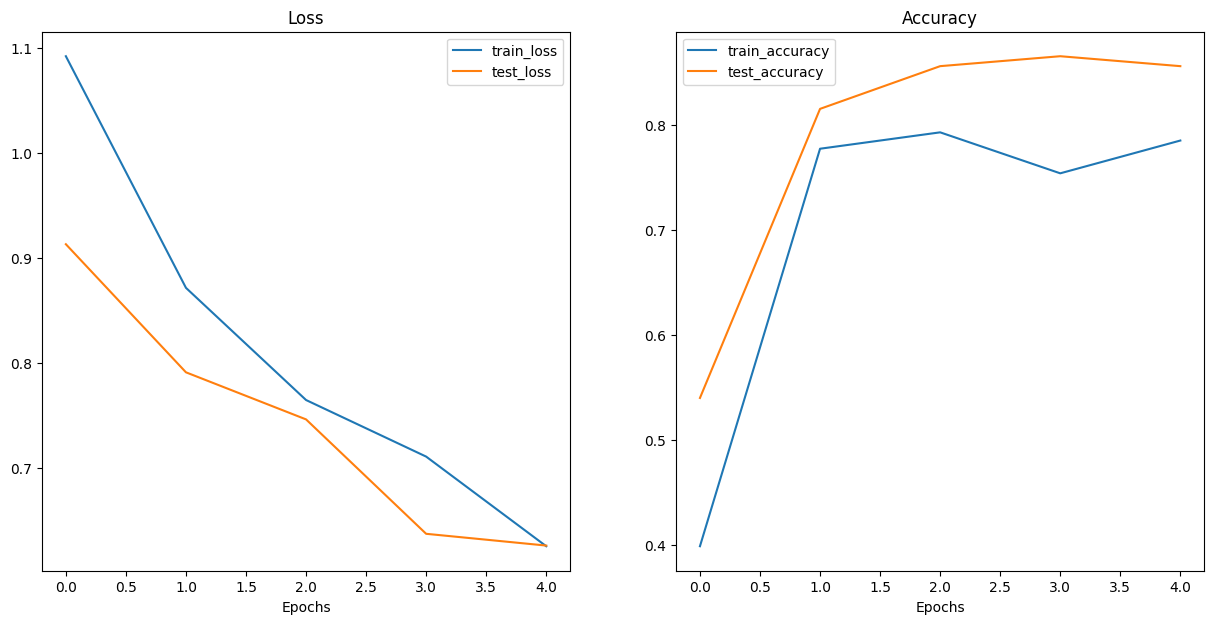

In [20]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_funtions.py downloading...")
  with open('helper_functions.py', "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)

  from helper_functions import plot_loss_curves

  # Plot the loss curves of our model
  plot_loss_curves(results)

## 6. Making predictions on images from the test set

Things to keep in mind when making prediction/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype
* Same device
* Same transform

To do all of this automagically, let's create a function called `pred_and_plot_image()`

Things to do in the function:
1. Take in a trained model, a list of class names, a filepat to a target imaqge, an image size, a tranform and a target device
2. Opne the image with PIL.Image.Open()
3. Create a transform if one doesn't exists
4. Make sure the model is on the target device
5. Turn the model to model.eval() mode to make sure it's ready for inference (this will turn off things like nn.Dropout())
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using torch.softmax()
9. Convert model's prediction probabilities to prediction labels using torch.argmax()
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8

In [21]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int,int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):

  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Creata a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])

  # 4. Moving the model to the target device
  model.to(device)

  # 5. turing on evaluation mode
  model.eval()
  with torch.inference_mode():

    # 6. Transforming the image to the same as the image on which the model was trained
    transformed_img = image_transform(img).unsqueeze(dim = 0)
    transformed_img = transformed_img.to(device)

    # 7. Making a prediction on the image by passing it through the model
    prediction_image_logits = model(transformed_img)

    # 8. Converting the output to prediction probabilty
    prediction_image_prob = torch.softmax(prediction_image_logits, dim = 1)

    # 9. Convrting the prediction probabilty to predictions
    prediction_image = torch.argmax(prediction_image_prob, dim = 1)

    # 10. Plotting the image using matplotlib
    plt.figure()
    image_label = class_names[prediction_image.squeeze(dim=0)]

    title = f"{image_label} | {prediction_image_prob.max():.3f}"

    plt.imshow(img)
    plt.title(title)
    plt.axis(False);


In [22]:


# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(test_image_path_list, num_images_to_plot)
test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg')]

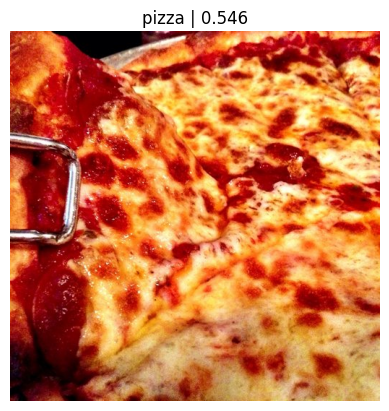

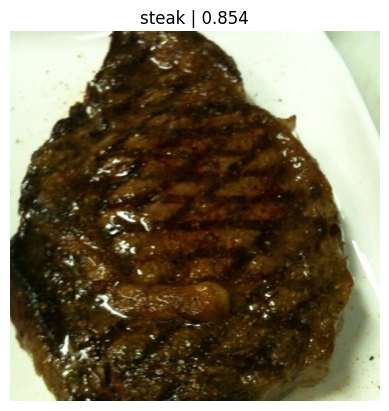

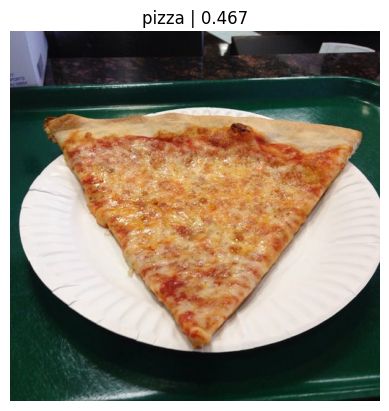

In [23]:
# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224,224)
                      )

### 6.1 Making predictions on a custom image


In [24]:
# Download the image

import requests

# setup custom image path
custom_image_path = data_path / "pizza_dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    print("Downloading pizza dad image")
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print("Pizza dad image already exits")

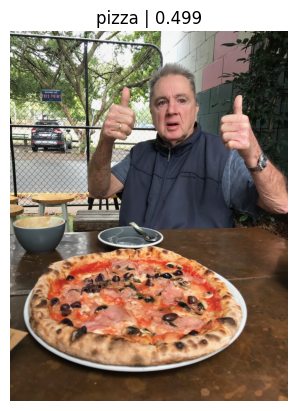

In [25]:
pred_and_plot_image(model = model,
                    image_path = custom_image_path,
                    class_names = class_names)